### Python Implementation of MUPE for General Nonlinear Models

In [1]:
# libraries required for MUPE curve fitting
import numpy as np
from lmfit import Model, Parameters
# run "conda install -c conda-forge lmfit" to install lmfit

# libraries used for demonstration purposes
import pandas as pd
from numpy.random import default_rng
import matplotlib.pyplot as plt

General nonlinear instantiation of the Minimum Unbiased Percent Error technique (MUPE) for multiplicative error models, which utilizes Iteratively Re-weighted Least Squares (IRLS) with weights equal to the squared inverse predictions from the prior iteration. Utilizes the MINPACK library implementation of the Levenberg-Marquardt algorithm.
<br>Usage Example:  mdict = mupe_nonlinear(func=my_func, y=df['y'], X=df['x'], start=(('a',10), ('b',1)))
    - 'func' must be a function you have defined that specifies the model form 
    (see examples)
    - 'y' is the response variable
    - 'X' is the driver variable (see example for multivariate case)
    - 'start' is a tuple of tuples providing the initial guess, or starting point for optimization. Parameter labels must match those used in 'func'. Whenever possible, provide values of the correct sign and order of magnitude. For 
    log-linear model forms, use the LOLS or PING solution as the initial guess.
Returns a dictionary containing an lmfit.model.ModelResult object and accompanying details.

#### Define function

In [2]:
def mupe_nonlinear(func, y, X, start):
    model = Model(func)        # create lmfit model from input function
    parameters = Parameters()  # initialize starting guess
    for p,v in start:
        parameters.add(name=p, value=v)
    # initialize prior coefficients
    coeffs_prior = np.array(list(parameters.valuesdict().values()))
    w = [1]*y.size  # initialize weights
    for i in range(200):
        # Levenberg-Marquardt optimization
        LM = model.fit(y, X=X, params=parameters, weights=w, max_nfev=10)
        w = 1/LM.best_fit  # reset weights
        # coefficients of current solution
        coeffs = np.array(list(LM.best_values.values()))
        if np.allclose(coeffs_prior, coeffs): break  # stop if converged
        coeffs_prior = coeffs                # reset prior coefficients
        parameters = Parameters();  j = 0    # reset starting guess
        for p,v in start:
            parameters.add(name=p, value=coeffs[j]);  j = j + 1
    return {'model':LM, 'start':start, 'mupe_iters':i}

#### Generate data to demonstrate equation of the form y = a * x^b

In [3]:
rng = default_rng(0);  n = 20;  x = rng.uniform(1000, 8000, n)
cv = 0.4;  loc = np.log(1 / np.sqrt(cv**2 + 1))
shape = np.sqrt(np.log(1 + cv**2))
y = 90 * x**1.3 * rng.lognormal(loc, shape, n)
df = pd.DataFrame({'y':y, 'x':x})

In [4]:
# function must use capital 'X' as its independent variable
def func1(X, a, b):
    return a * X**b
test1 = mupe_nonlinear(func1, y=df['y'], X=df['x'], 
                       start=(('a',10), ('b',1)))
test1

{'model': <lmfit.model.ModelResult at 0x1ff5dbd2648>,
 'start': (('a', 10), ('b', 1)),
 'mupe_iters': 8}

In [5]:
test1['model']

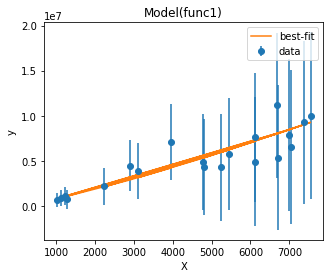

In [6]:
# univariate cases can use the built-in plotting functionality
fig1 = plt.figure(figsize=(5,4))
_ = test1['model'].plot_fit()

#### Generate data to demonstrate multivariate equation of the form y = a * x0^b * x1^c

In [7]:
rng = default_rng(0);  n = 40
x0 = rng.uniform(20, 90, n);  x1 = rng.uniform(3, 15, n)
y = 11 * x0**0.7 * x1**1.15 * rng.normal(1, 0.25, n)
df = pd.DataFrame({'y':y, 'x0':x0, 'x1':x1})

In [8]:
# function must use capital 'X' as its independent variable
def func2(X, a, b, c):
    x0 = X.iloc[:,0]
    x1 = X.iloc[:,1]
    return a * x0**b * x1**c
test2 = mupe_nonlinear(func2, y=df['y'], X=df[['x0','x1']], 
                       start=(('a',1), ('b',1), ('c',1)))
test2

{'model': <lmfit.model.ModelResult at 0x1ff5f793f08>,
 'start': (('a', 1), ('b', 1), ('c', 1)),
 'mupe_iters': 4}

In [9]:
test2['model']

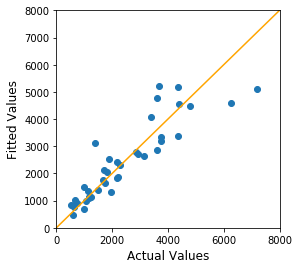

In [10]:
fig2 = plt.figure(figsize=(4,4))
ax2 = fig2.add_subplot()
plt.scatter(df['y'], test2['model'].best_fit)
plt.xlim(0, 8000);  plt.ylim(0, 8000)
x_line = np.linspace(0, 8000, 100)
_ = plt.plot(x_line, x_line, color='orange')
_ = ax2.set_ylabel('Fitted Values', fontsize='large')
_ = ax2.set_xlabel('Actual Values', fontsize='large')